# Importar librerías

In [8]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

# Leer datos

Trabajaremos con el conjunto de datos Box and Jenkins (1976) Airline Passengers (Pasajeros aéreos), que contiene datos de serie de tiempo del número mensual de pasajeros entre 1949 y 1960.

In [9]:
df = pd.read_csv('AirPassengers.csv')

df.head(5)

,Month,AirPassengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


# Adecuar los datos al formato requerido por Prophet

Prophet requiere que la columna de tiempo esté en el formato "datetime""

In [10]:
df.dtypes

Month            object
AirPassengers     int64
dtype: object

In [11]:
df['Month'] = pd.DatetimeIndex(df['Month'])
df.dtypes

Month            datetime64[ns]
AirPassengers             int64
dtype: object

También requiere que las columnas se llamen "ds" y "y", respectivamente

In [12]:
df = df.rename(columns={'Month': 'ds',
                        'AirPassengers': 'y'})

df.head(5)

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


# Visualización de los datos

Siempre es buena práctica ver cómo son los datos

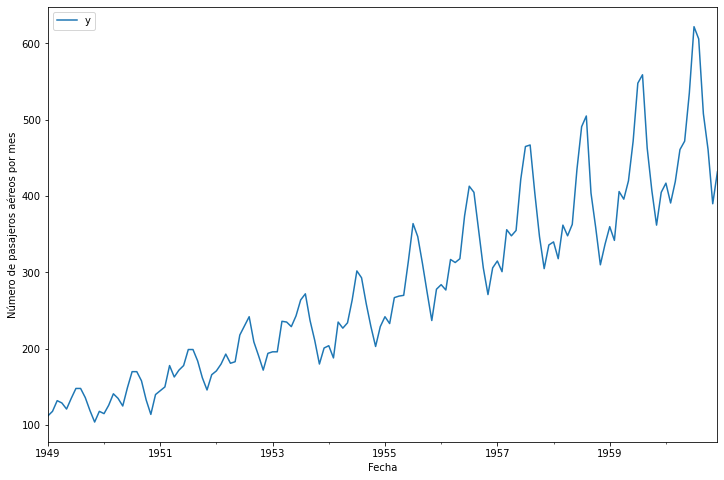

In [ ]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Número de pasajeros aéreos por mes')
ax.set_xlabel('Fecha')

plt.show();

# Predicción con Prophet

Debemos instanciar un objeto de la Clase Prophet

In [35]:
# fijar el intervalo de incertidumbre en 95% (el default de Prophet es 80%)
mi_modelo = Prophet(interval_width = 0.95)

Ajustamos el modelo con los datos del dataframe

In [36]:
mi_modelo.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


      99       401.676    0.00248047       124.072           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       401.794   6.53748e-05       58.9607   1.051e-06       0.001      209  LS failed, Hessian reset 
     199       401.842   7.96656e-05       76.5629           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       401.847   9.58429e-06       62.8741   1.173e-07       0.001      341  LS failed, Hessian reset 
     299       401.875   0.000423503       97.4976           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       401.939   0.000255806       95.7883   2.552e-06       0.001      496  LS failed, Hessian reset 
     399       401.979   1.11763e-05       84.0776           1           1      610   
    Iter      log prob        ||dx||      |

Para obtener predicciones, se debe provee al Prophet un nuevo DataFrame que contenga una columna "ds" con las fechas para las cuales se quiere una predicción.  No es necesario crear este nuevo DataFrame manualmente ya que Prophet contiene una función que lo hace:  make_future_dataframe()

Le indicaremos que queremos 36 nuevas fechas que representan meses

In [37]:
fechas_futuras = mi_modelo.make_future_dataframe(periods=36, freq='MS')
fechas_futuras.tail()

,ds
175,1963-08-01
176,1963-09-01
177,1963-10-01
178,1963-11-01
179,1963-12-01


Este DataFrame de fechas futuras se utiliza como entrada al método "predict" de nuestro modelo ajustado.

In [38]:
prediccion = mi_modelo.predict(fechas_futuras)

El Prophet devuelve un DataFrame grande con muchas columnas interesantes.  Sin embargo, vamos a pedirle solo aquellas columnas que son las más relevantes para la predicción.  Estas son:

ds: el tiempo de el valor predicho
yhat: tel valor predicho de nuestra métrica (en la Estadística, yhat es una notación que tradicionalmente se usa para representar los valores predichos de un valor y )
yhat_lower: el límite inferior de nuestras predicciones
yhat_upper: el límite superior de nuestras predicciones

In [39]:
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
175,1963-08-01,650.713914,604.251564,696.059643
176,1963-09-01,603.461648,562.427526,646.919681
177,1963-10-01,567.230030,521.843461,612.157616
178,1963-11-01,535.404764,491.909866,578.852368
179,1963-12-01,565.026903,520.561236,607.769050


Es de esperar variaciones en los resultados que se ven arriba ya que Prophet se vale de métodos 
Markov Chain Monte Carlo (MCMC) para generar las predicciones.  MCMC es un proceso estocástico, por lo que los valores serán levemente diferentes cada vez que se ejecuta.

Prophet también provee una conveniente función para graficar los resultados de la predicción

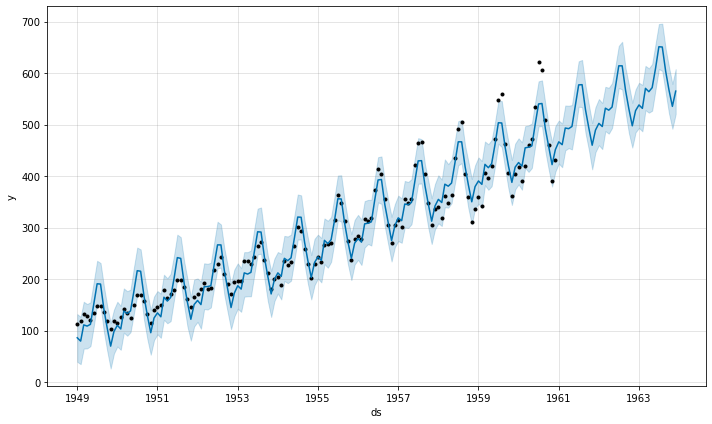

In [40]:
mi_modelo.plot(prediccion,
               uncertainty=True);

La gráfica muestra los valores observados de nuestra serie de tiempo (los puntos negros), los valored predichos (la línea azul) y los intervalos de incertiddumbres de las predicciones (las regiones sombreadas en azul).

Una característica particularmente fuerte de Prophet es su habilidad para mostrar los componentes de las predicciones.  Esto puede ayudar a revelar cómo contribuyen los patrones diarios, semanales y anuales de la serie de tiempo al valor global, o total, de las predicciones: 

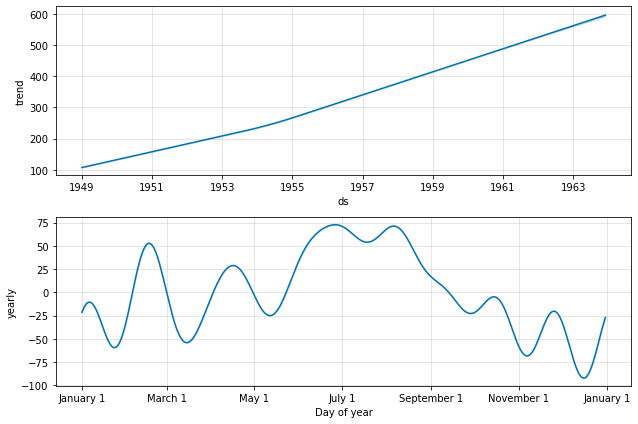

In [27]:
mi_modelo.plot_components(prediccion);